In our project we have to detect the real time emotions of students so that teachers can understand if students are able to grasp the topic according to students expressions or emotions.
So in our project , we first train the model on specific dataset through CNN , then with the help of opencv we capture the real time image , then apply our trained model on that image to detect the emotion of the person .
We made the frontend with the help of streamlit and deployed the entire model on heruko cloud.

In this ipynb file we will train the model on a dataset.

The dataset consists of 2 folders - training and test
All the images of dataset are grayscale images of size 48,48
Both these folders consist of 7 folders each- angry ,disguist,fear,happy,neutral,sad,suprise
All these 7 folders contain images of peoples faces with respective emotion.
We deleted 2 folders out of 7 which consisted of least numbers of images so that our model can train better on other model and give better accuracy.

<u>**Importing Recquired Libraries**

In [ ]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

<u>**Reading DataSet**

In [ ]:
# Reading input path
INPUT_PATH = "/content/drive/MyDrive/fer13"

In [ ]:
# count of emotions.
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

fear has 2535 number of images
Angry has 2832 number of images
Neutral has 4295 number of images
disgust has 380 number of images
Happy has 6834 number of images

total images are 16876


The above values shows that 'Happy' images count is majority and 'Disgust' images count is in minority. So i would like to drop minority count images from data.

In [ ]:
# Removing disgust emotion
Final_emotions = ['Fear','Angry','Neutral','Happy']

In [ ]:
#Loading images into an array
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in Final_emotions:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all fear images to numpy arrays
loaded all Angry images to numpy arrays
loaded all Neutral images to numpy arrays
loaded all Happy images to numpy arrays


((16876, 48, 48, 3), array([0., 0., 0., ..., 0., 0., 0.]))

In [ ]:
# so these are converted and have respective labels
label_to_text

{0: 'fear', 1: 'Angry', 2: 'Neutral', 3: 'Happy'}

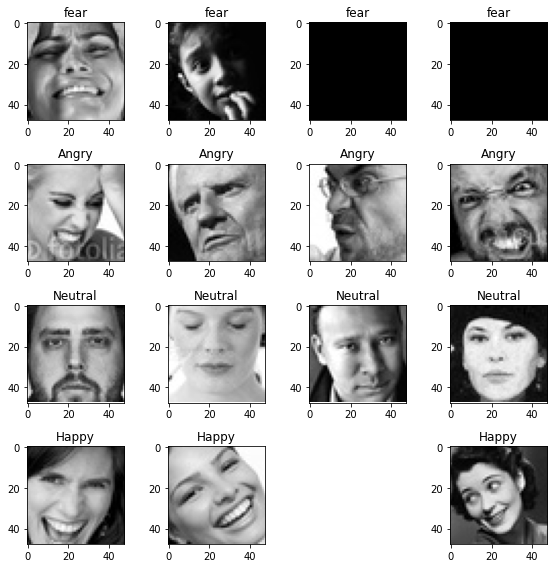

In [ ]:
#lets check some pictures of these emotions
fig = pyplot.figure(1, (8,8))

index = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        index += 1
        ax = pyplot.subplot(4,4,index)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [ ]:
img_label

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
#Converting class vector to binary class matrix
img_label = np_utils.to_categorical(img_label)
img_label.shape

(16876, 4)

In [ ]:
img_label

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [ ]:
#Normalizing the data
img_arr = img_arr / 255.

In [ ]:
# Splitting Data 
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15188, 48, 48, 3), (1688, 48, 48, 3), (15188, 4), (1688, 4))

In [ ]:
# Defining width, height, depth, and number of classes
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

<u>**Tansfer Learning- MobileNet**

We are going to use transfer learning model called MobileNet and build our model on it

We will use the weights of ImageNet, so that we end up with faster learning and good accuracy

In [ ]:
#Defining transfer learning model
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

# include_top = we have kept it as false since we didnt wanted to include the fully-connected layer at the top
# weights = we are using the weights of pretrained model ie imagenet, for faster learning
# input_shape is provided as include_top is false. because we will use our defined top layer as we need to change the 
# input size for using our model


x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
output = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)
# emotion is predicted. softmax activation function is used as it will give the ranking

model = Model(inputs=mobile_net.input, outputs=output)

17227776/17225924 [==============================] - 0s 0us/step


<u>**Model Summary**

In [ ]:
#Summary of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 24, 24, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 24, 24, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 24, 24, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 24, 24, 32)        0     

In [ ]:
## so we can see, we have (48,48,3) as the input size for our model

<u>**Fitting the Model**

In [ ]:
for layer in model.layers[:15]:
    layer.trainable = False  # Freeze the layer

In [ ]:
#Augumenting Training images
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [ ]:
"""
I am using two callbacks

`early stopping` for avoiding overfitting of training data

`ReduceLROnPlateau` for learning rate.
"""
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)
callbacks = [
    early_stopping,
    lr_scheduler]

In [ ]:
#Fitting the model
batch_size = 25
epochs = 40

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',           # loss= categorical_crossentropy since we have more then 2 class
        optimizer=optims[1],                       # optims = to find optimal weights 
        metrics=['accuracy']                       # accuracy is criterian to improve performance
)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
593/593 [==============================] - 24s 31ms/step - loss: 1.8087 - accuracy: 0.4295 - val_loss: 1.0770 - val_accuracy: 0.5636
Epoch 2/40
593/593 [==============================] - 16s 28ms/step - loss: 0.9962 - accuracy: 0.5911 - val_loss: 0.9906 - val_accuracy: 0.5964
Epoch 3/40
593/593 [==============================] - 17s 29ms/step - loss: 0.9257 - accuracy: 0.6332 - val_loss: 0.8397 - val_accuracy: 0.6655
Epoch 4/40
593/593 [==============================] - 17s 28ms/step - loss: 0.8692 - accuracy: 0.6594 - val_loss: 1.0336 - val_accuracy: 0.5648
Epoch 5/40
593/593 [==============================] - 17s 29ms/step - loss: 0.8530 - accuracy: 0.6604 - val_loss: 0.8920 - val_accuracy: 0.6897
Epoch 6/40
593/593 [==============================] - 17s 29ms/step - loss: 0.8200 - accuracy: 0.6819 - val_loss: 1.0959 - val_accuracy: 0.5515
Epoch 7/40
593/593 [==============================] - 17s 29ms/step - loss: 0.8121 - accuracy: 0.6750 - val_loss: 0.9985 - val_accuracy:

In [ ]:
model.save("model.h5")

<u>**Model Evaluation**

In [ ]:
## so we are having around 75% of accuracy in both the cases

test accuracy: 75.7576 %


              precision    recall  f1-score   support

           0       0.70      0.55      0.62       253
           1       0.63      0.64      0.63       283
           2       0.66      0.76      0.71       430
           3       0.90      0.88      0.89       684

    accuracy                           0.76      1650
   macro avg       0.72      0.71      0.71      1650
weighted avg       0.76      0.76      0.76      1650



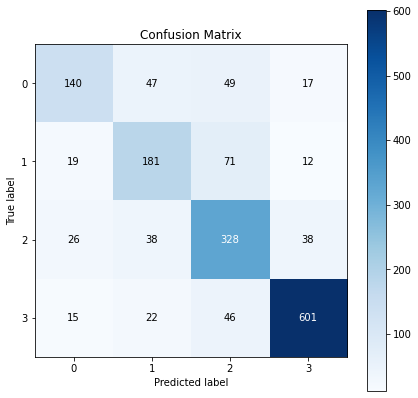

In [ ]:
# Classification Report and confusion matrix
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("model_confusion_matrix.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

The confusion matrix clearly shows that model is doing good job on the class happy but it's performance is not that good on other classes. One of the reason for this could be the fact that these classes have less data as compared to happy.

In [ ]:
'''The reason for low accuracy is the data quality. there are miss-classified images in the dataset. 
Many of them doesn't belong to their true class but are actually looking more likely to the predicted class. '''